Imports and definition. Adapt according to your working directory and module structure

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/jmerten/codes/mydnn/mydnn/cv')
sys.path.append('/home/jmerten/codes/mydnn/mydnn/cnn')
sys.path.append('/home/jmerten/codes/mydnn/mydnn/utils')
from features import *
from classification import *
from datasets import *
import keras
from keras.models import load_model

Using TensorFlow backend.


Some necessary label definition and other little helpers

In [2]:
my_labels = np.array(['f4','f4_03ev','f5','f5_015ev','f5_01ev','f6','f6_006ev','f6_01ev','lcdm'])

In [3]:
def plot_boxes(predictions,filename):
    plot_label = np.array(['$\mathbf{f_{4}}$','$\mathbf{f_{4}^{0.3}}$','$\mathbf{f_{5}}$','$\mathbf{f_{5}^{0.15}}$','$\mathbf{f_{5}^{0.1}}$','$\mathbf{f_{6}}$','$\mathbf{f_{6}^{0.06}}$','$\mathbf{f_{6}^{0.1}}$','$\mathbf{\Lambda\mathrm{CDM}}$'])
    fig, axes = plt.subplots(3,3,figsize=(20,14.1))
    boxes = []
    running_index = 0
    for i in range(0,3):
        for j in range(0,3):
            model_index = i*3+j
            boxes.append(axes[i,j].boxplot((predictions[model_index,0,:],predictions[model_index,1,:],predictions[model_index,2,:],predictions[model_index,3,:],predictions[model_index,4,0:],predictions[model_index,5,:],predictions[model_index,6,:],predictions[model_index,7,:],predictions[model_index,8,:]),showfliers=False,notch=True,bootstrap=1000))
            y = boxes[running_index]['boxes'][running_index].get_xydata().T[1][3]
            y_u = boxes[running_index]['boxes'][running_index].get_xydata().T[1][4]
            y_l = boxes[running_index]['boxes'][running_index].get_xydata().T[1][2]
            x_plot = range(0,12)
            y_plot = np.zeros_like(x_plot)+y
            y_u_plot = np.zeros_like(x_plot)+y_u
            y_l_plot = np.zeros_like(x_plot)+y_l
            axes[i,j].plot(x_plot,y_plot,'r',lw=1,alpha=.75)
            axes[i,j].fill_between(x_plot,y_u_plot,y_l_plot,alpha=.5)
            axes[i,j].set_ylim([0.0,1.])
            axes[i,j].set_title(plot_label[model_index], fontsize=50, fontweight='bold')
            axes[i,j].set_yticks([0,.2,.4,.6,.8,1.])
            axes[i,j].set_xticklabels(plot_label)
            axes[i,j].spines['top'].set_linewidth(0)
            axes[i,j].spines['bottom'].set_linewidth(3)
            axes[i,j].spines['left'].set_linewidth(3)
            axes[i,j].spines['right'].set_linewidth(0)
            axes[i,j].grid(axis='y')
            if(j != 0):
                axes[i,j].set_yticklabels([])
            if(i != 2):
                axes[i,j].set_xticklabels([])       
            index = 0
            for this in boxes[running_index]['boxes']:
                boxes[running_index]['boxes'][index].set_linewidth(3)
                if(index!= running_index):
                    if(this.get_xydata().T[1][3] > boxes[running_index]['boxes'][running_index].get_xydata().T[1][3]):
                        this.set_color('red')
                    elif(this.get_xydata().T[1][2] > boxes[running_index]['boxes'][running_index].get_xydata().T[1][4]):
                        this.set_color('orange')
                    else:
                        this.set_color('green')
                index += 1
            plt.setp(axes[i,j].get_yticklabels(), rotation='horizontal', fontsize=35, fontweight='bold')
            plt.setp(axes[i,j].get_xticklabels(), rotation=45, fontsize=42,fontweight='bold')
            running_index += 1
    plt.tight_layout()
    fig.savefig(filename,dpi=150)

def produce_predictions(classification,elements):
    predictions = np.zeros([9,9,elements],dtype=float)
    index = 0
    for label in classification.labels:
        mask = classification.ground_truth == label
        predictions[index,:,:] = classification.data[mask].T
        index += 1
    return predictions

def create_ground_truth_labels(labels,num=2457):
    out = np.empty(num*len(labels),dtype='S20')
    index = 0
    for item in labels:
        out[index*num:(index+1)*num] = item
        index += 1
    return out

def table_out(classi):
    text_label = np.array(['$f_{4}$','$f_{4}^{0.3}$','$f_{5}$','$f_{5}^{0.15}$','$f_{5}^{0.1}$','$f_{6}$','$f_{6}^{0.06}$','$f_{6}^{0.1}$','$\Lambda$CDM']) 
    class_index = 0
    for label in classi.labels:
        num = float(classi.class_samples[class_index])
        out_str_t = text_label[class_index] 
        out_str_c = ""
        out_str_b = ""
        out_str_n = ""
        for index in range(0,classi.num_classes):
            if(index == class_index):
                out_str_t += '& '+ r"\textbf{" +str(classi.numbers[class_index][index])+"}"
                out_str_c += '&' + r"\textbf{" + str(int(np.floor(classi.numbers[class_index][index]/num*100+0.5)))+"\%"+"}"
                out_str_b += '&' + r"$\mathbf{" +str(np.around(classi.means[class_index][index],decimals=3))+"}$"
                out_str_n += '&' + r"$\mathbf{\pm"+str(np.around(classi.stdevs[class_index][index]/np.sqrt(num),decimals=3))+"}$"
            else:
                out_str_t += '&' +str(classi.numbers[class_index][index])
                out_str_c += '&' +str(int(np.floor(classi.numbers[class_index][index]/num*100+0.5)))+"\%"
                out_str_b += '&$' +str(np.around(classi.means[class_index][index],decimals=3)) +"$"
                out_str_n += '&$\pm' +str(np.around(classi.stdevs[class_index][index]/np.sqrt(num),decimals=3))+"$"
        out_str_t += r"\\"
        out_str_c += r"\\"
        out_str_b += r"\\" 
        out_str_n += r"\\"+" \hline"
        print out_str_t    
        print out_str_c
        print out_str_b
        print out_str_n                             
        class_index += 1

Loading models based on feature distances

In [6]:
path_wnd_dist_z10 = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/wnd_dist_z10.h5'
path_classic_dist_z10 = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/classic_dist_z10.h5'

In [7]:
classification_wnd_dist_z10 = load_from_file(path_wnd_dist_z10,labels=my_labels)
classification_classic_dist_z10 = load_from_file(path_classic_dist_z10,labels=my_labels)

In [8]:
classification_wnd_dist_z10.execute()
classification_classic_dist_z10.execute()

In [9]:
classification_wnd_dist_z10.print_summary()

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  22113  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  2457  samples.
They were classified as: 
f4           	|	1030 / 2457 	|	41.9 %
f4_03ev      	|	175 / 2457 	|	7.12 %
f5           	|	465 / 2457 	|	18.9 %
f5_015ev     	|	203 / 2457 	|	8.26 %
f5_01ev      	|	185 / 2457 	|	7.52 %
f6           	|	107 / 2457 	|	4.35 %
f6_006ev     	|	102 / 2457 	|	4.15 %
f6_01ev      	|	72 / 2457 	|	2.93 %
lcdm         	|	118 / 2457 	|	4.80 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.681860756764
f4_03ev      	|	0.412852952239 +/- 0.258175344962
f5           	|	0.791539572932 +/- 0.416766476474
f5_015ev     	|	0.603743744377 +/- 0.172508970817
f5_01ev      	|	0.730387543859 +/- 0.268522684071
f6           	|	0.490125867132 +/- 0.189700025717
f6_006ev     	|	0.45892608

In [10]:
classification_classic_dist_z10.print_summary()

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  22113  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  2457  samples.
They were classified as: 
f4           	|	896 / 2457 	|	36.4 %
f4_03ev      	|	89 / 2457 	|	3.62 %
f5           	|	557 / 2457 	|	22.6 %
f5_015ev     	|	198 / 2457 	|	8.05 %
f5_01ev      	|	298 / 2457 	|	12.1 %
f6           	|	161 / 2457 	|	6.55 %
f6_006ev     	|	114 / 2457 	|	4.63 %
f6_01ev      	|	84 / 2457 	|	3.41 %
lcdm         	|	60 / 2457 	|	2.44 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.700518848238
f4_03ev      	|	0.328903862659 +/- 0.250265445251
f5           	|	0.820475143998 +/- 0.431351806121
f5_015ev     	|	0.545574686973 +/- 0.24084758269
f5_01ev      	|	0.720670811263 +/- 0.293871751646
f6           	|	0.492965249163 +/- 0.253711251945
f6_006ev     	|	0.436639893941

Producing model predictions

In [11]:
predictions_wnd_dist_z10 = produce_predictions(classification_wnd_dist_z10,2457)
predictions_classic_dist_z10 = produce_predictions(classification_classic_dist_z10,2457)

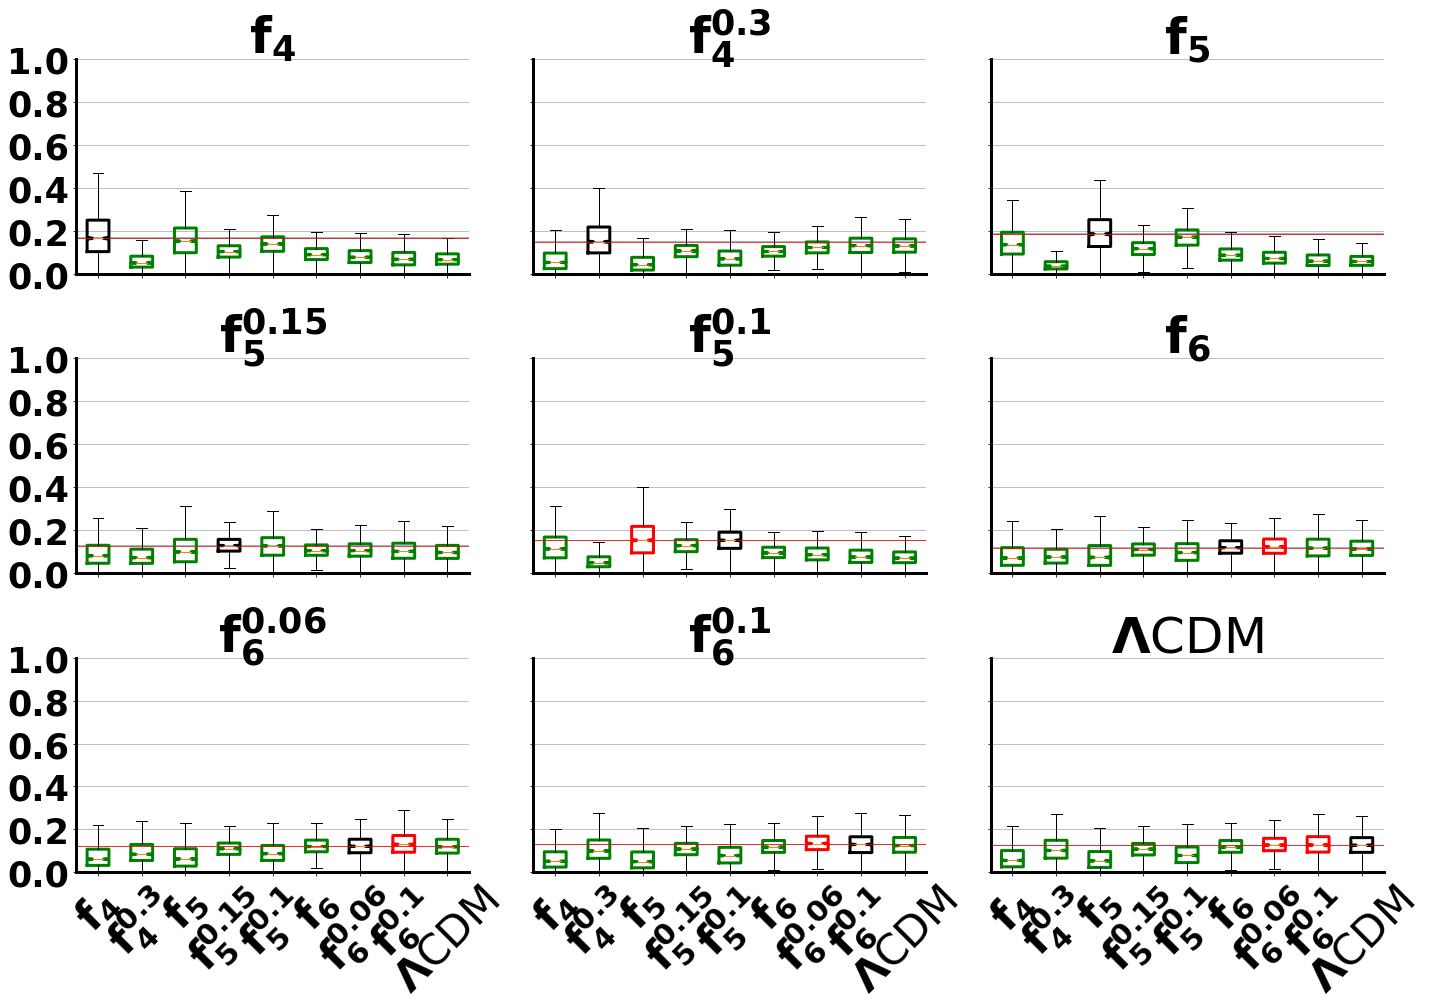

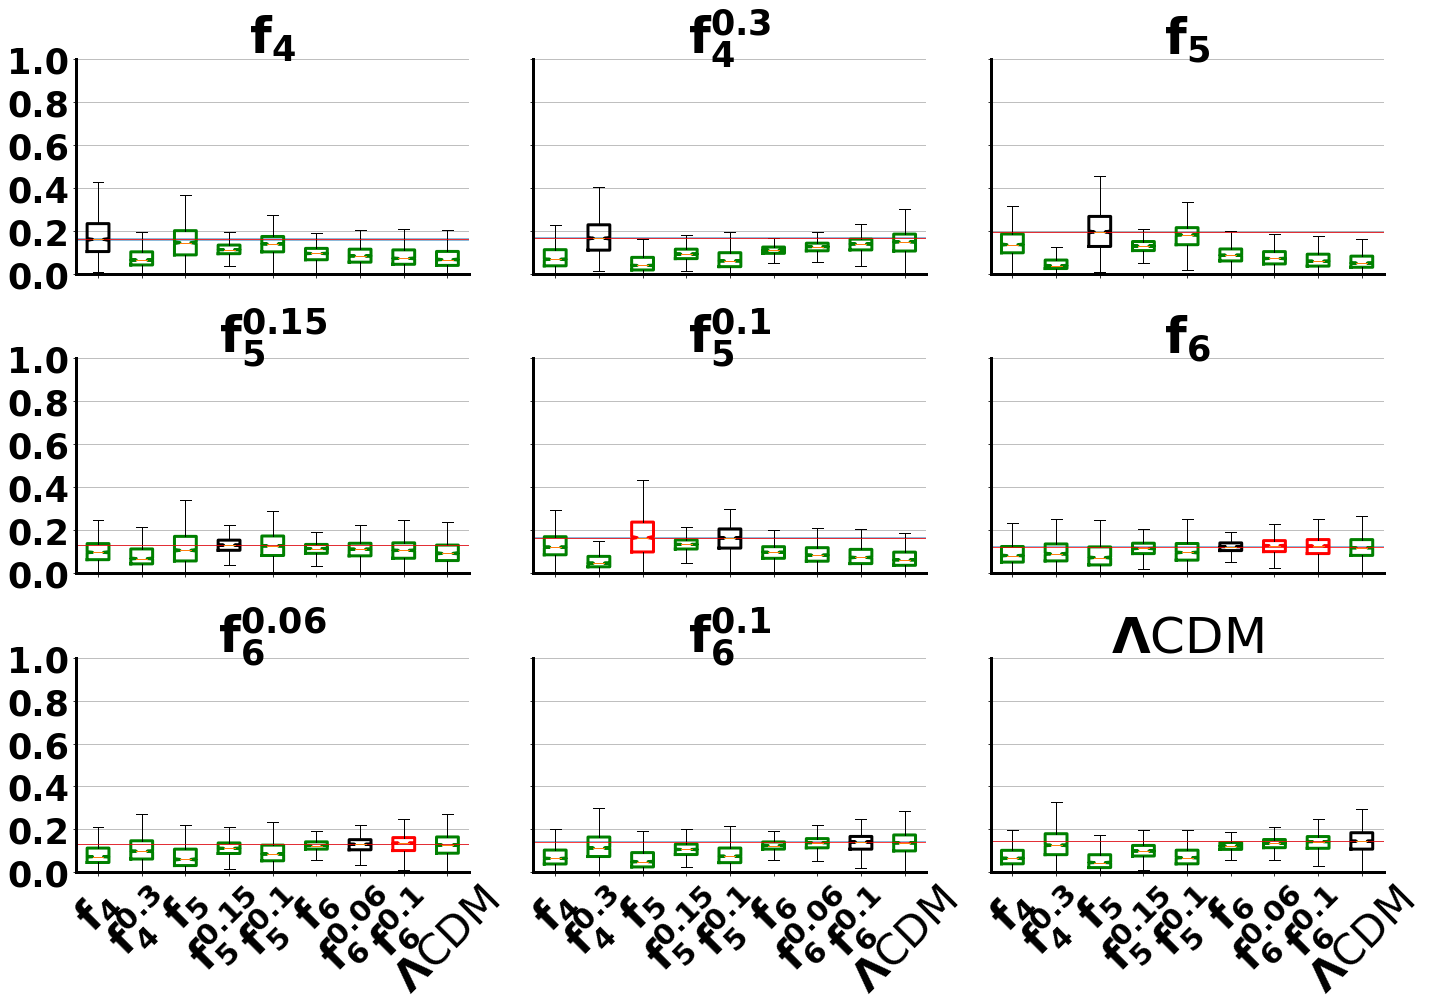

In [20]:
plot_boxes(predictions_classic_dist_z10,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_classic_dist.png')
plot_boxes(predictions_wnd_dist_z10,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_wnd_dist.png')

Analysing fixed feature methods with neural network classifier, the feature files are actually quite big, too big for the repository (several Gb). If you want to perform this analysis, please request them separately. 

In [21]:
classic_train_fit = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/classic_train.fit' 
classic_test_fit = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/classic_classify.fit'
wnd_train_fit = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/wnd_train.fit' 
wnd_test_fit = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/wnd_test.fit'

In [22]:
classic_features = wndcharm_features(classic_train_fit)
wnd_features = wndcharm_features(wnd_train_fit)

In [23]:
classic_features.normalise()
wnd_features.normalise()

In [24]:
classic_features.calculate_fisher()
wnd_features.calculate_fisher()

In [25]:
classic_features.load_validation_set_fromfit(classic_test_fit)
wnd_features.load_validation_set_fromfit(wnd_test_fit)

/home/jmerten/codes/mydnn/mydnn/cv/features.py:148: RuntimeWarning: divide by zero encountered in divide
  self.validation_weights /= self.feature_shifts[:,1]
/home/jmerten/codes/mydnn/mydnn/cv/features.py:148: RuntimeWarning: invalid value encountered in divide
  self.validation_weights /= self.feature_shifts[:,1]


In [26]:
x_classic_train, y_classic_train, x_classic_test, y_classic_test = classic_features.return_train_test_data()
x_wnd_train, y_wnd_train, x_wnd_test, y_wnd_test = wnd_features.return_train_test_data()

In [27]:
classic_nn_model_path = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/classic_nn_z10.h5'
wnd_nn_model_path = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/wnd_nn_z10.h5'

In [29]:
classic_nn_model = load_model(classic_nn_model_path)
wnd_nn_model = load_model(wnd_nn_model_path)

In [30]:
classic_nn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
wnd_nn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
predictions_classic_nn = classic_nn_model.predict(x_classic_test,verbose=1)
predictions_wnd_nn = wnd_nn_model.predict(x_wnd_test,verbose=1)

22113/22113 [==============================] - 1s 60us/step


In [32]:
labels_classic_nn = create_ground_truth_labels(my_labels,num=1638)
labels_wnd_nn = create_ground_truth_labels(my_labels)

In [33]:
classification_classic_nn_z10 = classification(predictions_classic_nn,labels=my_labels,input_truth=labels_classic_nn)
classification_wnd_nn_z10 = classification(predictions_wnd_nn,labels=my_labels,input_truth=labels_wnd_nn)

In [34]:
classification_classic_nn_z10.execute()
classification_wnd_nn_z10.execute()

In [35]:
classification_classic_nn_z10.print_summary()

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  14742  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  1638  samples.
They were classified as: 
f4           	|	958 / 1638 	|	58.4 %
f4_03ev      	|	80 / 1638 	|	4.88 %
f5           	|	157 / 1638 	|	9.58 %
f5_015ev     	|	103 / 1638 	|	6.28 %
f5_01ev      	|	97 / 1638 	|	5.92 %
f6           	|	137 / 1638 	|	8.36 %
f6_006ev     	|	26 / 1638 	|	1.58 %
f6_01ev      	|	24 / 1638 	|	1.46 %
lcdm         	|	56 / 1638 	|	3.41 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.70834416682
f4_03ev      	|	0.138786183382 +/- 0.277693108253
f5           	|	0.32502297836 +/- 0.356678445886
f5_015ev     	|	0.220852758918 +/- 0.213819235101
f5_01ev      	|	0.292504216137 +/- 0.247418325294
f6           	|	0.231539659603 +/- 0.213034346026
f6_006ev     	|	0.182301225285 +/

In [36]:
classification_wnd_nn_z10.print_summary()

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  22113  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  2457  samples.
They were classified as: 
f4           	|	1509 / 2457 	|	61.4 %
f4_03ev      	|	157 / 2457 	|	6.38 %
f5           	|	207 / 2457 	|	8.42 %
f5_015ev     	|	102 / 2457 	|	4.15 %
f5_01ev      	|	148 / 2457 	|	6.02 %
f6           	|	152 / 2457 	|	6.18 %
f6_006ev     	|	53 / 2457 	|	2.15 %
f6_01ev      	|	42 / 2457 	|	1.70 %
lcdm         	|	87 / 2457 	|	3.54 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.709107860009
f4_03ev      	|	0.155537100223 +/- 0.301855418748
f5           	|	0.30082818093 +/- 0.345618210675
f5_015ev     	|	0.182617178938 +/- 0.183403535928
f5_01ev      	|	0.280880291476 +/- 0.246566760884
f6           	|	0.214534359615 +/- 0.198119145437
f6_006ev     	|	0.17933046011

In [37]:
predictions_wnd_nn_z10 = produce_predictions(classification_wnd_nn_z10,2457)
predictions_classic_nn_z10 = produce_predictions(classification_classic_nn_z10,1638)

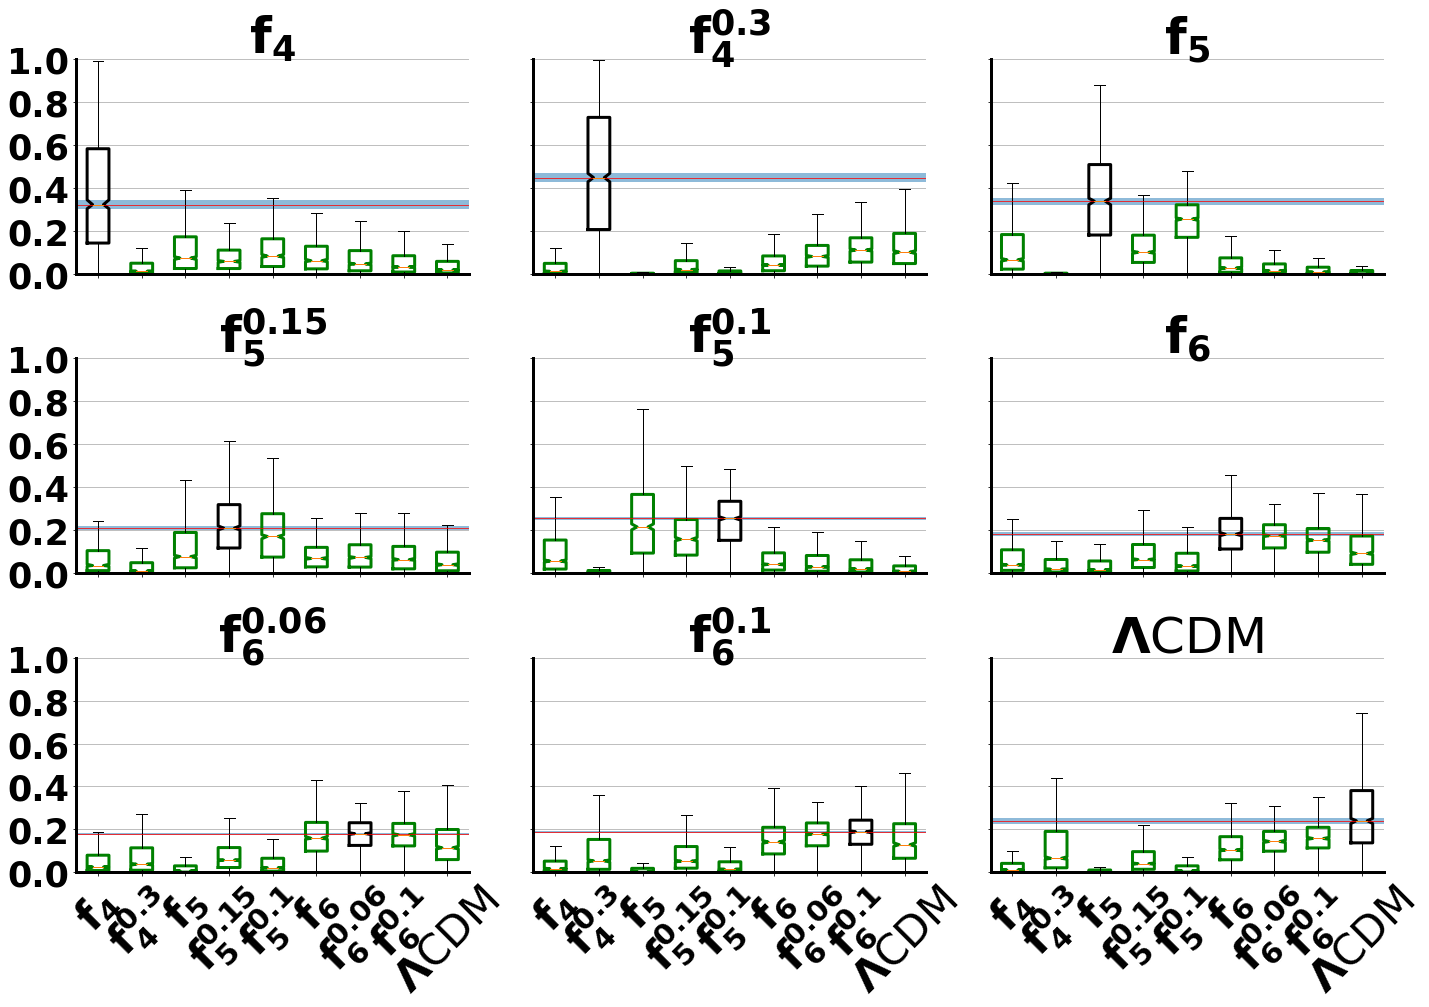

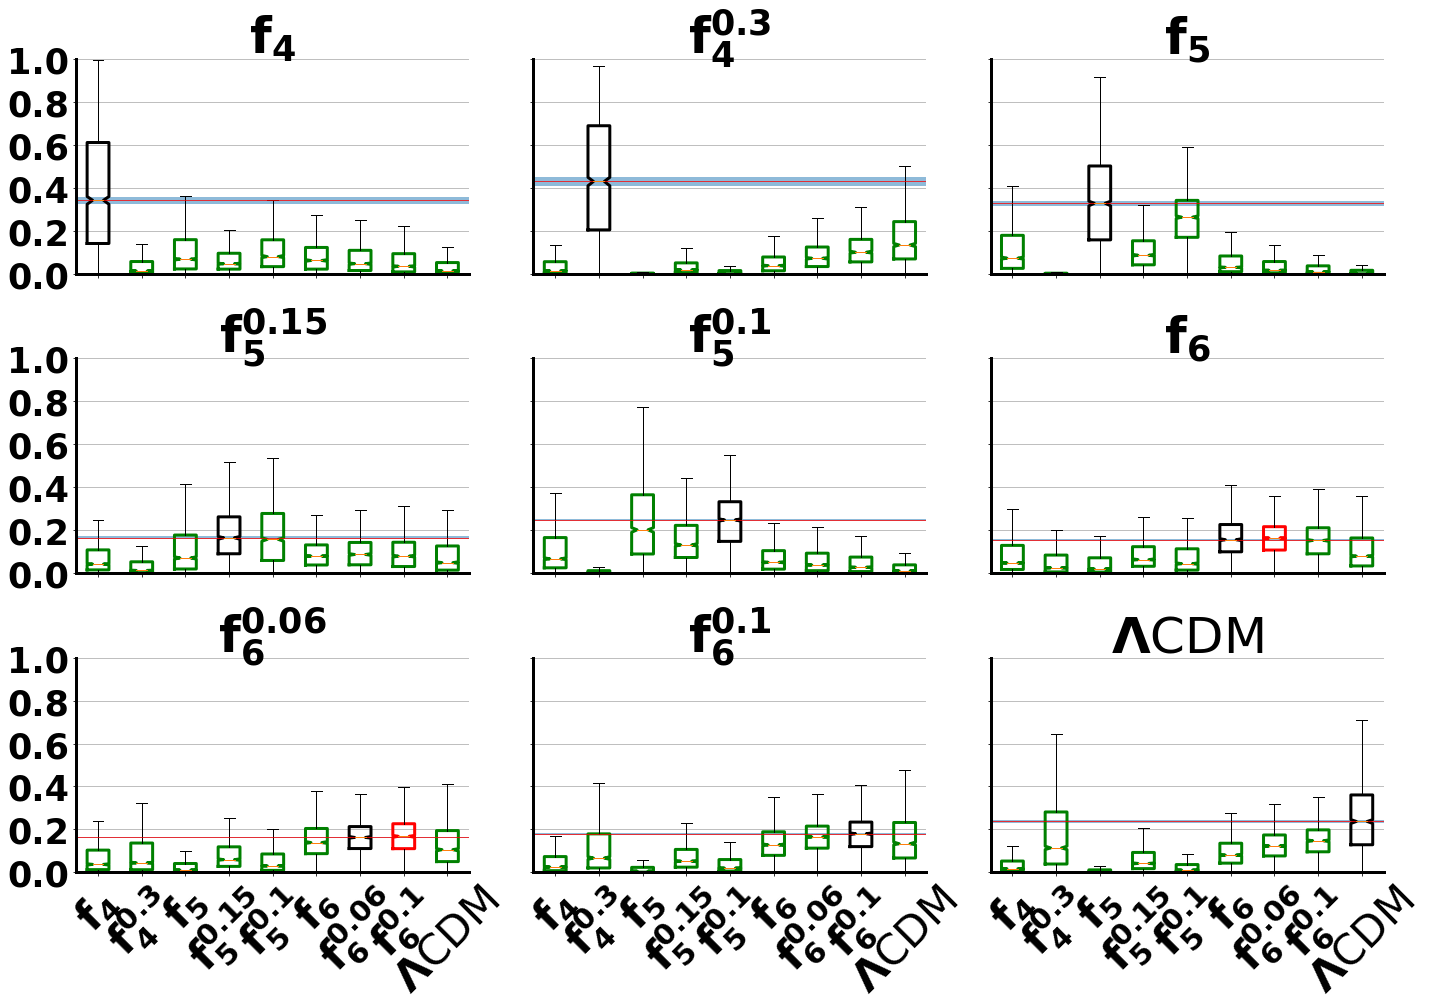

In [38]:
plot_boxes(predictions_classic_nn_z10,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_classic_nn.png')
plot_boxes(predictions_wnd_nn_z10,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_wnd_nn.png')

Now loading the CNNs

In [39]:
table_out(classification_classic_nn_z10)

$f_{4}$& \textbf{958}&80&157&103&97&137&26&24&56\\
&\textbf{58\%}&5\%&10\%&6\%&6\%&8\%&2\%&1\%&3\%\\
&$\mathbf{0.376}$&$0.052$&$0.122$&$0.083$&$0.11$&$0.087$&$0.068$&$0.056$&$0.046$\\
&$\mathbf{\pm0.007}$&$\pm0.003$&$\pm0.003$&$\pm0.002$&$\pm0.002$&$\pm0.002$&$\pm0.002$&$\pm0.001$&$\pm0.002$\\ \hline
$f_{4}^{0.3}$&70& \textbf{1135}&1&72&10&18&31&116&185\\
&4\%&\textbf{69\%}&0\%&4\%&1\%&1\%&2\%&7\%&11\%\\
&$0.05$&$\mathbf{0.468}$&$0.006$&$0.052$&$0.018$&$0.058$&$0.091$&$0.12$&$0.137$\\
&$\pm0.002$&$\mathbf{\pm0.007}$&$\pm0.001$&$\pm0.002$&$\pm0.001$&$\pm0.001$&$\pm0.002$&$\pm0.002$&$\pm0.003$\\ \hline
$f_{5}$&232&6& \textbf{857}&158&275&84&10&5&11\\
&14\%&0\%&\textbf{52\%}&10\%&17\%&5\%&1\%&0\%&1\%\\
&$0.129$&$0.008$&$\mathbf{0.354}$&$0.129$&$0.246$&$0.055$&$0.036$&$0.026$&$0.018$\\
&$\pm0.004$&$\pm0.001$&$\mathbf{\pm0.005}$&$\pm0.003$&$\pm0.002$&$\pm0.002$&$\pm0.001$&$\pm0.001$&$\pm0.001$\\ \hline
$f_{5}^{0.15}$&149&90&173& \textbf{651}&254&120&38&52&111\\
&9\%&5\%&11\%&\textbf{40\%}&1

In [1]:
path_CNN_z10 = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/CNN_z10.h5'
path_CNN_z05 = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/CNN_z05.h5'
path_CNN_z20 = '/home/jmerten/codes/mydnn/reproducible_science/merten18/models/CNN_z20.h5'

In [41]:
CNN_z10 = load_model(path_CNN_z10)
CNN_z05 = load_model(path_CNN_z05)
CNN_z20 = load_model(path_CNN_z20)

/home/jmerten/anaconda2/envs/py27/lib/python2.7/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [42]:
CNN_z10.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
CNN_z05.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
CNN_z20.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
test_data_flow = Dustgrain_H5_datagenerator('/dati1/jmerten/dustgrain_pathfinder/dustgrain_train_test_classify_split_256_slices_4z_channels.h5',classes=my_labels,sample='classify',channels=np.array((1,)),batch_size=1,shuffle=False)

In [44]:
results_CNN_z10 = CNN_z10.predict_generator(test_data_flow,verbose=1)

14742/14742 [==============================] - 655s 44ms/step


In [9]:
labels_CNN = create_ground_truth_labels(my_labels,num=1638)

In [46]:
classification_CNN_z10 = classification(results_CNN_z10,labels=my_labels,input_truth=labels_CNN)
classification_CNN_z10.execute()
classification_CNN_z10.print_summary()
predictions_CNN_z10 = produce_predictions(classification_CNN_z10,1638)

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  14742  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  1638  samples.
They were classified as: 
f4           	|	1307 / 1638 	|	79.7 %
f4_03ev      	|	116 / 1638 	|	7.08 %
f5           	|	36 / 1638 	|	2.19 %
f5_015ev     	|	21 / 1638 	|	1.28 %
f5_01ev      	|	31 / 1638 	|	1.89 %
f6           	|	88 / 1638 	|	5.37 %
f6_006ev     	|	12 / 1638 	|	0.73 %
f6_01ev      	|	5 / 1638 	|	0.30 %
lcdm         	|	22 / 1638 	|	1.34 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.494105237226
f4_03ev      	|	0.131232299162 +/- 0.254941367689
f5           	|	0.0700951276839 +/- 0.134570219186
f5_015ev     	|	0.0546176874876 +/- 0.0947923890754
f5_01ev      	|	0.0771862384451 +/- 0.12295797861
f6           	|	0.0751026127677 +/- 0.1415002257
f6_006ev     	|	0.0559466332935

In [47]:
table_out(classification_CNN_z10)

$f_{4}$& \textbf{1307}&116&36&21&31&88&12&5&22\\
&\textbf{80\%}&7\%&2\%&1\%&2\%&5\%&1\%&0\%&1\%\\
&$\mathbf{0.646}$&$0.085$&$0.045$&$0.035$&$0.05$&$0.049$&$0.036$&$0.025$&$0.028$\\
&$\mathbf{\pm0.008}$&$\pm0.004$&$\pm0.002$&$\pm0.002$&$\pm0.002$&$\pm0.002$&$\pm0.002$&$\pm0.001$&$\pm0.002$\\ \hline
$f_{4}^{0.3}$&51& \textbf{1298}&0&11&0&7&8&27&236\\
&3\%&\textbf{79\%}&0\%&1\%&0\%&0\%&0\%&2\%&14\%\\
&$0.046$&$\mathbf{0.658}$&$0.001$&$0.014$&$0.004$&$0.02$&$0.031$&$0.037$&$0.19$\\
&$\pm0.003$&$\mathbf{\pm0.007}$&$\pm0.0$&$\pm0.001$&$\pm0.0$&$\pm0.001$&$\pm0.001$&$\pm0.002$&$\pm0.005$\\ \hline
$f_{5}$&105&1& \textbf{1065}&90&320&48&2&1&6\\
&6\%&0\%&\textbf{65\%}&5\%&20\%&3\%&0\%&0\%&0\%\\
&$0.064$&$0.002$&$\mathbf{0.444}$&$0.114$&$0.316$&$0.028$&$0.016$&$0.011$&$0.006$\\
&$\pm0.003$&$\pm0.0$&$\mathbf{\pm0.005}$&$\pm0.003$&$\pm0.002$&$\pm0.002$&$\pm0.001$&$\pm0.001$&$\pm0.001$\\ \hline
$f_{5}^{0.15}$&103&37&161& \textbf{721}&347&78&14&31&146\\
&6\%&2\%&10\%&\textbf{44\%}&21\%&5\%&1\%&2\%&9\

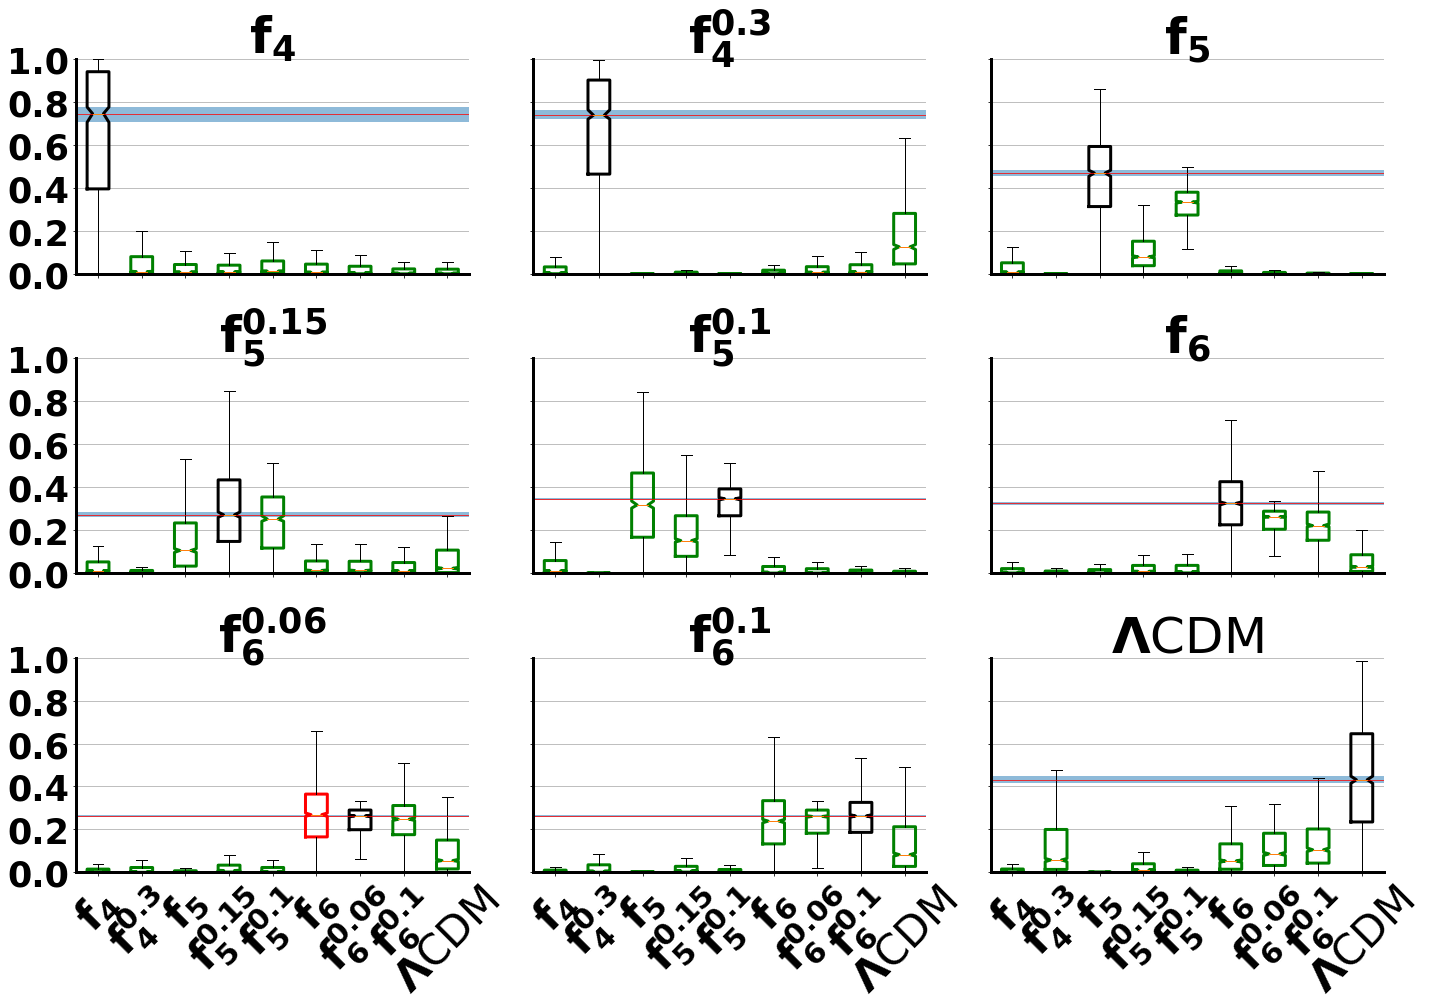

In [48]:
plot_boxes(predictions_CNN_z10,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_CNN_z10.png')

In [49]:
test_data_flow = Dustgrain_H5_datagenerator('/dati1/jmerten/dustgrain_pathfinder/dustgrain_train_test_classify_split_256_slices_4z_channels.h5',classes=my_labels,sample='classify',channels=np.array((0,)),batch_size=1,shuffle=False)

In [50]:
results_CNN_z05 = CNN_z05.predict_generator(test_data_flow,verbose=1)

14742/14742 [==============================] - 558s 38ms/step


In [51]:
classification_CNN_z05 = classification(results_CNN_z05,labels=my_labels,input_truth=labels_CNN)
classification_CNN_z05.execute()
classification_CNN_z05.print_summary()
predictions_CNN_z05 = produce_predictions(classification_CNN_z05,1638)

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  14742  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  1638  samples.
They were classified as: 
f4           	|	931 / 1638 	|	56.8 %
f4_03ev      	|	179 / 1638 	|	10.9 %
f5           	|	73 / 1638 	|	4.45 %
f5_015ev     	|	126 / 1638 	|	7.69 %
f5_01ev      	|	49 / 1638 	|	2.99 %
f6           	|	81 / 1638 	|	4.94 %
f6_006ev     	|	11 / 1638 	|	0.67 %
f6_01ev      	|	99 / 1638 	|	6.04 %
lcdm         	|	89 / 1638 	|	5.43 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.722086337435
f4_03ev      	|	0.293178566371 +/- 0.48680561124
f5           	|	0.20718930951 +/- 0.272677850563
f5_015ev     	|	0.237902870775 +/- 0.279291999259
f5_01ev      	|	0.210698033734 +/- 0.227294670341
f6           	|	0.203372008556 +/- 0.225156133273
f6_006ev     	|	0.192101217918 +/-

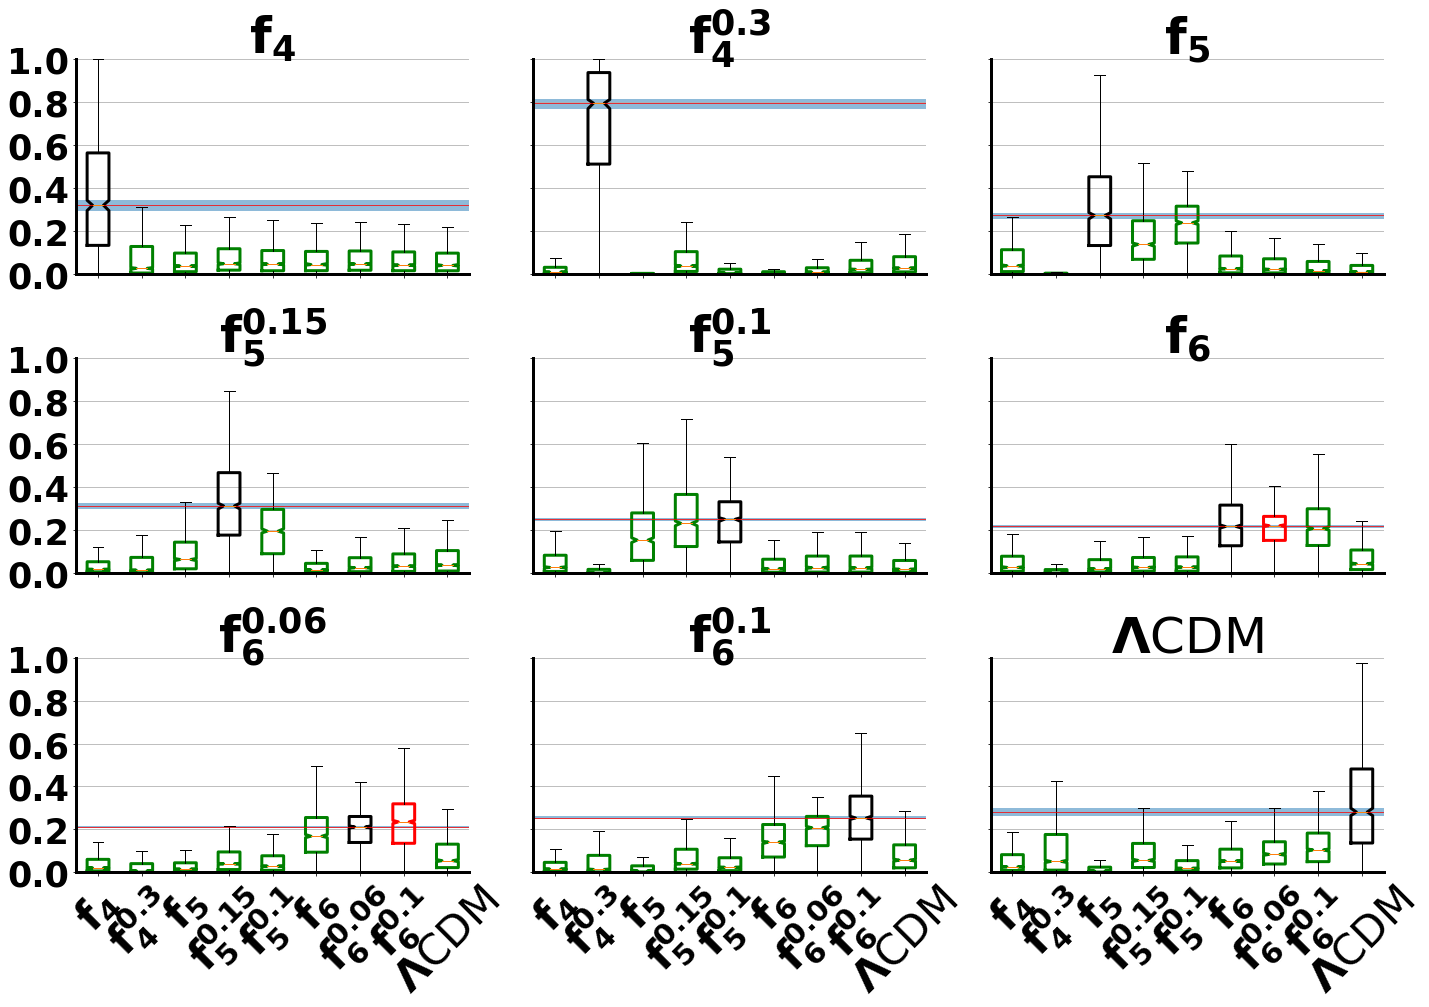

In [52]:
plot_boxes(predictions_CNN_z05,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_CNN_z05.png')

In [53]:
test_data_flow = Dustgrain_H5_datagenerator('/dati1/jmerten/dustgrain_pathfinder/dustgrain_train_test_classify_split_256_slices_4z_channels.h5',classes=my_labels,sample='classify',channels=np.array((3,)),batch_size=1,shuffle=False)

In [54]:
results_CNN_z20 = CNN_z20.predict_generator(test_data_flow,verbose=1)

14742/14742 [==============================] - 621s 42ms/step


In [55]:
classification_CNN_z20 = classification(results_CNN_z20,labels=my_labels,input_truth=labels_CNN)
classification_CNN_z20.execute()
classification_CNN_z20.print_summary()
predictions_CNN_z20 = produce_predictions(classification_CNN_z20,1638)

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  14742  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  1638  samples.
They were classified as: 
f4           	|	1525 / 1638 	|	93.1 %
f4_03ev      	|	16 / 1638 	|	0.97 %
f5           	|	26 / 1638 	|	1.58 %
f5_015ev     	|	4 / 1638 	|	0.24 %
f5_01ev      	|	31 / 1638 	|	1.89 %
f6           	|	34 / 1638 	|	2.07 %
f6_006ev     	|	1 / 1638 	|	0.06 %
f6_01ev      	|	0 / 1638 	|	0.0 %
lcdm         	|	1 / 1638 	|	0.06 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.271279510646
f4_03ev      	|	0.0155857043674 +/- 0.079370184578
f5           	|	0.0394106156345 +/- 0.102537712145
f5_015ev     	|	0.0118730115396 +/- 0.0417653693549
f5_01ev      	|	0.0414168613965 +/- 0.0948259793571
f6           	|	0.024214961609 +/- 0.0824053737071
f6_006ev     	|	0.0088260135685

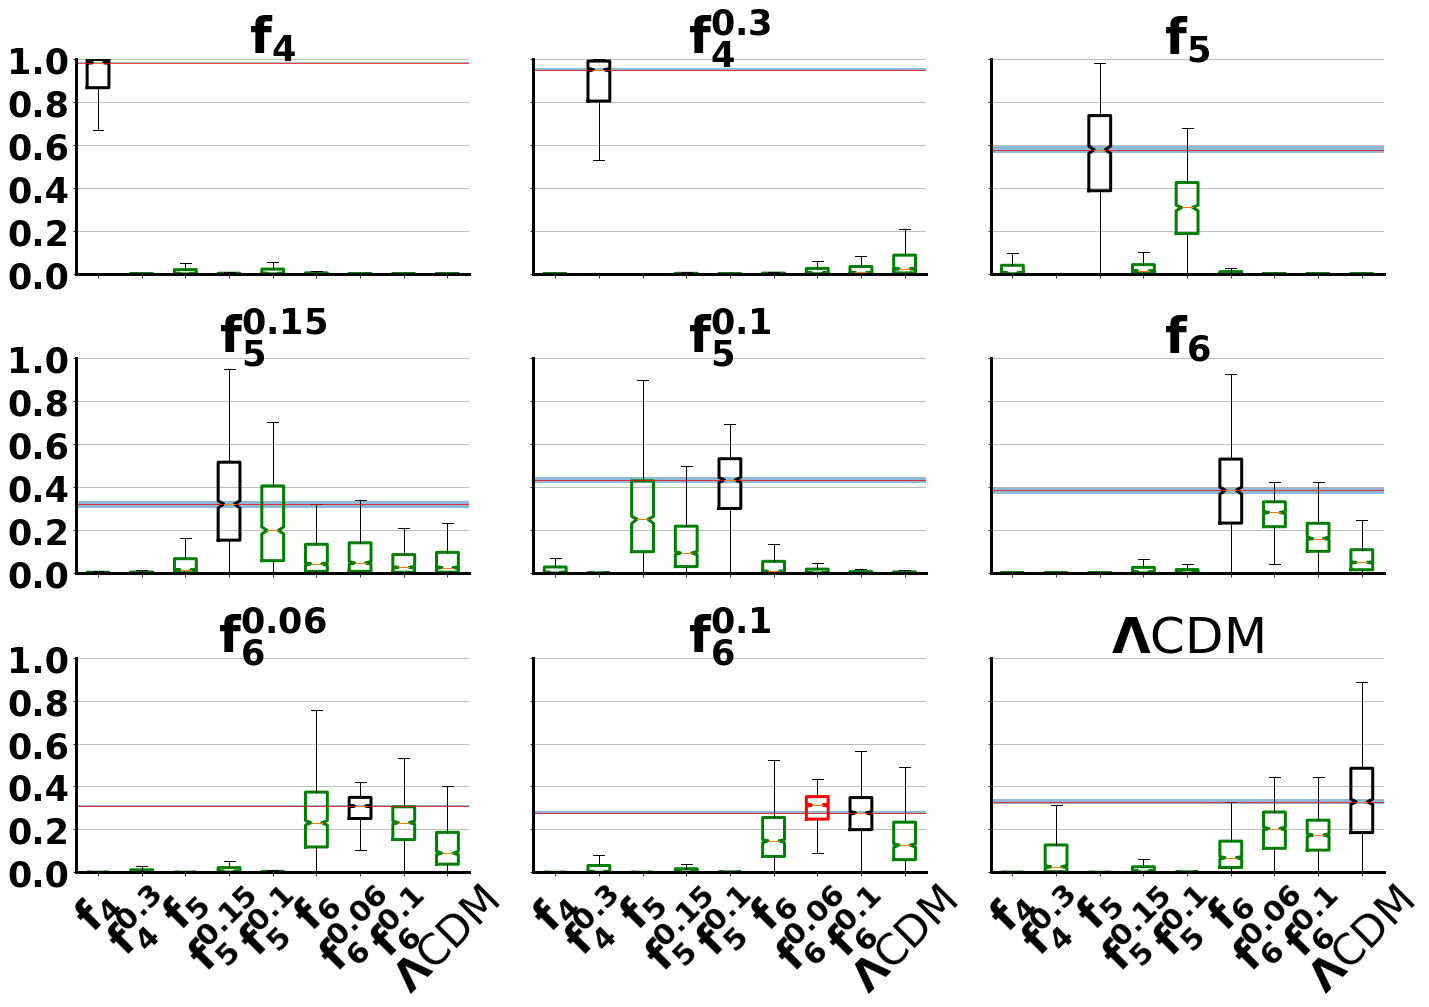

In [56]:
plot_boxes(predictions_CNN_z20,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_CNN_z20.png')

Tomographic analysis

In [5]:
path_CNN_tomo = '/dati1/jmerten/dustgrain_pathfinder/paper_data/final_models/CNN_tomographic.h5'
CNN_tomo = load_model(path_CNN_tomo)
CNN_tomo.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [6]:
test_data_flow = Dustgrain_H5_datagenerator('/dati1/jmerten/dustgrain_pathfinder/dustgrain_train_test_classify_split_256_slices_4z_channels.h5',classes=my_labels,sample='classify',channels=np.array((0,1,2,3)),batch_size=1,shuffle=False)

In [7]:
results_CNN_tomo = CNN_tomo.predict_generator(test_data_flow,verbose=1)

14742/14742 [==============================] - 682s 46ms/step


In [10]:
classification_CNN_tomo = classification(results_CNN_tomo,labels=my_labels,input_truth=labels_CNN)
classification_CNN_tomo.execute()
classification_CNN_tomo.print_summary()
predictions_CNN_tomo = produce_predictions(classification_CNN_tomo,1638)

This classifier knows the following classes: 
f4
f4_03ev
f5
f5_015ev
f5_01ev
f6
f6_006ev
f6_01ev
lcdm
The classification set contains  14742  samples.
The correct classification of the set is  known.


------------------------------
Report on: f4
Subset contains  1638  samples.
They were classified as: 
f4           	|	1618 / 1638 	|	98.7 %
f4_03ev      	|	0 / 1638 	|	0.0 %
f5           	|	7 / 1638 	|	0.42 %
f5_015ev     	|	0 / 1638 	|	0.0 %
f5_01ev      	|	10 / 1638 	|	0.61 %
f6           	|	3 / 1638 	|	0.18 %
f6_006ev     	|	0 / 1638 	|	0.0 %
f6_01ev      	|	0 / 1638 	|	0.0 %
lcdm         	|	0 / 1638 	|	0.0 %


What results in the following similarities: 
f4           	|	1.0 +/- 0.100813777389
f4_03ev      	|	0.000126144000101 +/- 0.00343980754124
f5           	|	0.006827559096 +/- 0.0649682700026
f5_015ev     	|	0.000325822969518 +/- 0.00571055207438
f5_01ev      	|	0.00583708118652 +/- 0.0562215172692
f6           	|	0.00221192727035 +/- 0.0319411594162
f6_006ev     	|	3.5004635603

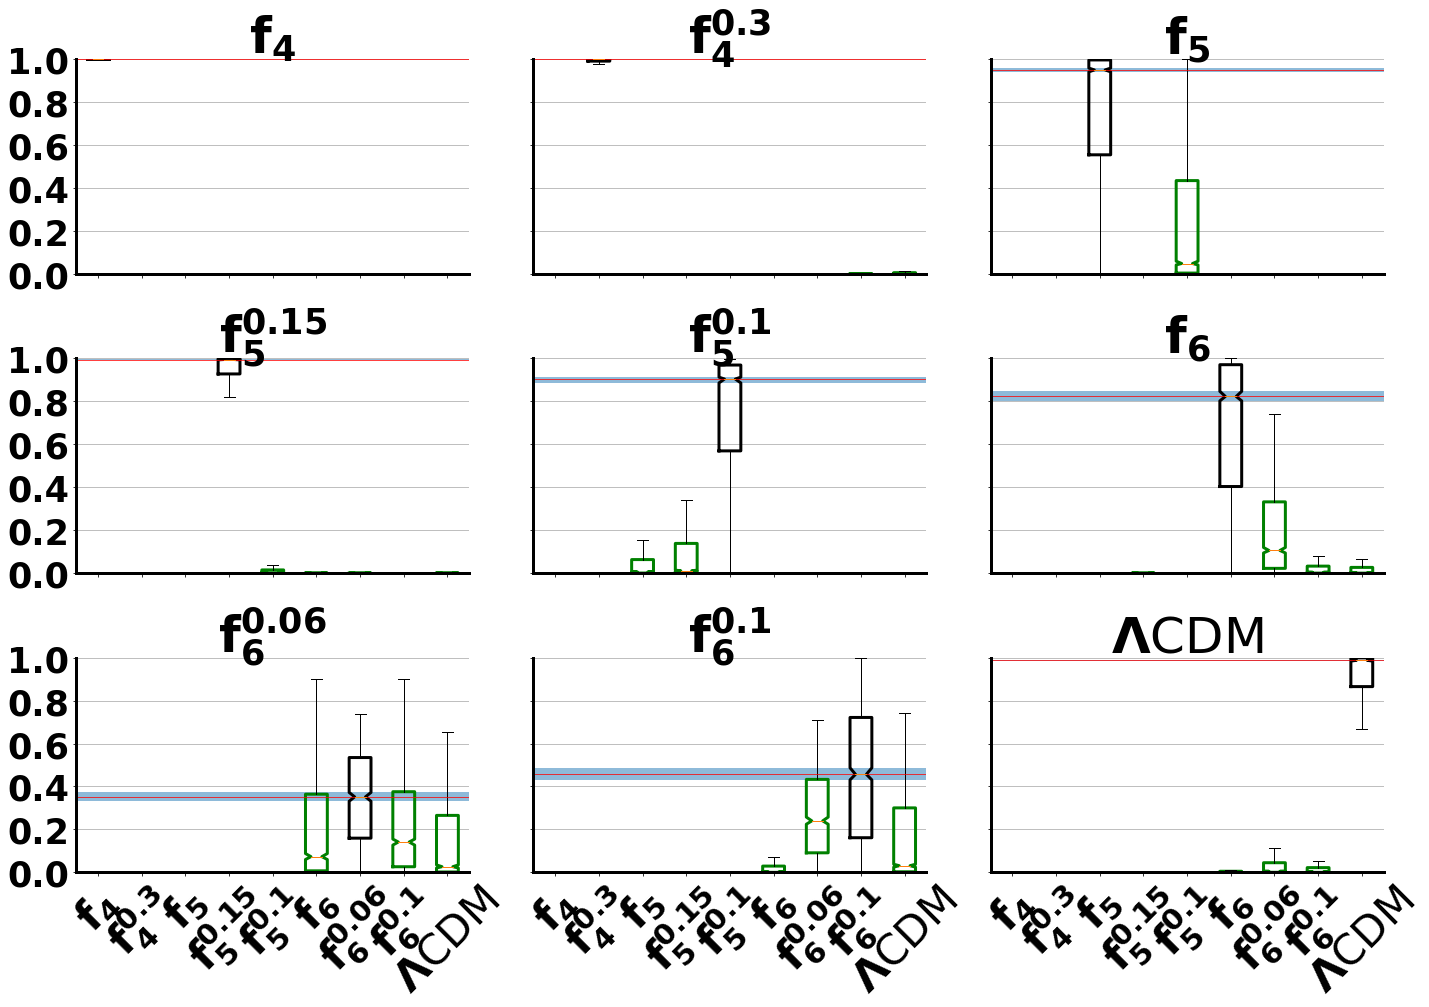

In [11]:
plot_boxes(predictions_CNN_tomo,'/home/jmerten/codes/mydnn/reproducible_science/merten18/figures/box_plot_CNN_tomo_p0.png')

In [12]:
table_out(classification_CNN_tomo)

$f_{4}$& \textbf{1618}&0&7&0&10&3&0&0&0\\
&\textbf{99\%}&0\%&0\%&0\%&1\%&0\%&0\%&0\%&0\%\\
&$\mathbf{0.985}$&$0.0$&$0.007$&$0.0$&$0.006$&$0.002$&$0.0$&$0.0$&$0.0$\\
&$\mathbf{\pm0.002}$&$\pm0.0$&$\pm0.002$&$\pm0.0$&$\pm0.001$&$\pm0.001$&$\pm0.0$&$\pm0.0$&$\pm0.0$\\ \hline
$f_{4}^{0.3}$&0& \textbf{1501}&0&1&0&0&1&20&115\\
&0\%&\textbf{92\%}&0\%&0\%&0\%&0\%&0\%&1\%&7\%\\
&$0.0$&$\mathbf{0.91}$&$0.0$&$0.001$&$0.0$&$0.0$&$0.002$&$0.015$&$0.072$\\
&$\pm0.0$&$\mathbf{\pm0.006}$&$\pm0.0$&$\pm0.0$&$\pm0.0$&$\pm0.0$&$\pm0.001$&$\pm0.002$&$\pm0.005$\\ \hline
$f_{5}$&3&0& \textbf{1257}&2&375&1&0&0&0\\
&0\%&0\%&\textbf{77\%}&0\%&23\%&0\%&0\%&0\%&0\%\\
&$0.001$&$0.0$&$\mathbf{0.748}$&$0.002$&$0.247$&$0.001$&$0.0$&$0.0$&$0.0$\\
&$\pm0.001$&$\pm0.0$&$\mathbf{\pm0.008}$&$\pm0.001$&$\pm0.008$&$\pm0.001$&$\pm0.0$&$\pm0.0$&$\pm0.0$\\ \hline
$f_{5}^{0.15}$&0&0&1& \textbf{1470}&96&22&7&2&40\\
&0\%&0\%&0\%&\textbf{90\%}&6\%&1\%&0\%&0\%&2\%\\
&$0.0$&$0.0$&$0.001$&$\mathbf{0.873}$&$0.071$&$0.015$&$0.009$&$0.0